conda create -n tp3_env python=3.11 -c conda-forge -y
conda activate tp3_env
conda install -c conda-forge numpy=1.26 scipy=1.11 scikit-learn=1.4 pandas matplotlib seaborn joblib xgboost -y
# Instalar paquetes pip que no están en conda-forge o prefieras pip
pip install sentence-transformers gensim vaderSentiment umap-learn
# Si usás Jupyter desde este entorno, registrar kernel
python -m ipykernel install --user --name tp3_env --display-name "tp3_env (py3.11)"

In [15]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import TargetEncoder

SEED = 42
np.random.seed(SEED)


In [16]:
train_path = 'data/train.csv'
df = pd.read_csv(train_path)

## 1) Feature engineering (común a ambos modelos)

In [17]:
# Limpieza y preprocesamiento básico de texto
def clean_text(s):
    if pd.isna(s):
        return ''
    s = str(s)
    s = s.lower()
    s = re.sub(r'http\S+', ' ', s)
    s = re.sub(r'www\S+', ' ', s)
    s = re.sub(r'[^\w\s#@]', ' ', s)
    s = re.sub(r'[\s_]+', ' ', s).strip()
    return s

df['text_clean'] = df['text'].apply(clean_text)
df['keyword'] = df['keyword'].fillna('no_keyword_contained')
df['location'] = df['location'].apply(clean_text)
df['location'] = df['location'].fillna('no_location_contained')

# Creación de features numéricas adicionales
df['word_count'] = df['text_clean'].apply(lambda s: len(s.split()))
df['text_len'] = df['text_clean'].apply(lambda s: sum(len(w) for w in s.split()))
df['mean_word_len'] = df.apply(lambda row: row['text_len'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)
df['num_hashtags'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('#'))
df['num_mentions'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('@'))

# Creación de features booleanas adicionales
df['has_url'] = df['text'].apply(lambda s: 0 if pd.isna(s) else (1 if 'http' in s or 'www.' in s else 0))
df['has_hashtag'] = df['num_hashtags'].apply(lambda x: 1 if x > 0 else 0)
df['has_mention'] = df['num_mentions'].apply(lambda x: 1 if x > 0 else 0)
df['location_mentioned'] = df.apply(lambda row: 1 if row['location'].lower() in row['text_clean'] else 0, axis=1)

disaster_terms = df['keyword'].dropna().unique().tolist()
def count_terms(s, terms=disaster_terms):
    s = s.lower()
    cnt = 0
    for t in terms:
        if t in s:
            cnt += 1
    return cnt

# Feature engineering adicional 
df['disaster_terms_count'] = df['text_clean'].apply(count_terms)
df['all_caps_count'] = df['text'].apply(lambda s: sum(1 for w in str(s).split() if w.isupper())).fillna(0)

analyzer = SentimentIntensityAnalyzer()

def vader_scores(text):
    if not isinstance(text, str) or text.strip() == "":
        return {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
    return analyzer.polarity_scores(text)

scores = [vader_scores(t) for t in df['text'].astype(str).tolist()]
scores_df = pd.DataFrame(scores)

df = pd.concat([df.reset_index(drop=True), scores_df.reset_index(drop=True)], axis=1)

In [18]:
location_appearings = df['location'].value_counts().to_dict()
df['location_clean'] = df['location'].map(lambda loc: loc if location_appearings[loc] > 2 else "other")

keyword_counts = df['keyword'].value_counts()
kw_Q1 = keyword_counts.quantile(0.25)
low_frequency_keywords = keyword_counts[keyword_counts < kw_Q1].to_dict()
df['keyword_clean'] = df['keyword'].map(lambda kw: kw if kw not in low_frequency_keywords else "other")

In [ ]:
num_features = ['text_len', 'word_count', 'mean_word_len',
                'num_hashtags', 'num_mentions', 'disaster_terms_count',
                'all_caps_count', 'neg', 'neu', 'pos', 'compound']
cat_features = ['location_clean', 'keyword_clean']
bool_features = ['has_url', 'has_hashtag', 'has_mention', 'location_mentioned']
emb_features = ['text_clean']
X = df[num_features + cat_features + bool_features + emb_features]
y = df['target'].astype(int).values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=SEED
)

In [20]:
loc_encoding = TargetEncoder(random_state=SEED)
loc_encoding.fit(X_train[['location_clean']], y_train)
X_train_loc_enc = loc_encoding.transform(X_train[['location_clean']])
X_val_loc_enc = loc_encoding.transform(X_val[['location_clean']])

kyw_encoding = TargetEncoder(random_state=SEED)
kyw_encoding.fit(X_train[['keyword_clean']], y_train)
X_train_kyw_enc = kyw_encoding.transform(X_train[['keyword_clean']])
X_val_kyw_enc = kyw_encoding.transform(X_val[['keyword_clean']])

X_train['location_enc'] = X_train_loc_enc
X_train['keyword_enc'] = X_train_kyw_enc
X_val['location_enc'] = X_val_loc_enc
X_val['keyword_enc'] = X_val_kyw_enc
num_features += ['location_enc', 'keyword_enc']


preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('bool', 'passthrough', bool_features)
], remainder='drop')

X_train_proc = preprocessor.fit_transform(X_train[num_features + bool_features])
X_val_proc = preprocessor.transform(X_val[num_features + bool_features])


In [21]:
from sentence_transformers import SentenceTransformer
model_name = "all-MiniLM-L6-v2"
sbert = SentenceTransformer(model_name)

In [22]:
X_train_sbert = sbert.encode(X_train['text_clean'].astype(str).tolist(), convert_to_numpy=True)
X_val_sbert = sbert.encode(X_val['text_clean'].astype(str).tolist(), convert_to_numpy=True)

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
assert X_train_proc.shape[0] == y_train.shape[0]
assert X_train_sbert.shape[0] == y_train.shape[0]
assert X_val_proc.shape[0] == y_val.shape[0]
assert X_val_sbert.shape[0] == y_val.shape[0]

# 1) Concatenar tabulares + embeddings (columnas: primero tabulares, luego embeddings)
X_train_combined = np.hstack((X_train_proc, X_train_sbert))
X_val_combined   = np.hstack((X_val_proc,   X_val_sbert))

n_tab = X_train_proc.shape[1]
n_emb = X_train_sbert.shape[1]

# 2) ColumnTransformer: scale solo las primeras n_tab columnas
# Usamos indices para seleccionar columnas. ColumnTransformer acepta lista de índices.
preprocessor = ColumnTransformer(transformers=[
    ("num_scaled", StandardScaler(), list(range(0, n_tab))),
    # dejamos embeddings sin transformar -> passthrough
    ("emb_passthrough", "passthrough", list(range(n_tab, n_tab + n_emb)))
], remainder="drop")  # no quedan columnas extras

# 3) Pipeline: preprocessor + XGB
xgb = XGBClassifier(
    objective="binary:logistic",
    device='cuda',  
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=SEED,
    tree_method="auto"  # si tenés GPU y versión de xgboost con GPU: 'gpu_hist'
)

pipe = Pipeline([
    ("pre", preprocessor),
    ("xgb", xgb)
])

# 4) GridSearchCV (ejemplo razonable; ajustar según tiempo)
param_grid = {
    'xgb__n_estimators': [100, 300],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__max_depth': [3, 6],
    'xgb__subsample': [0.7, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    # si querés probar regularización:
    # 'xgb__reg_alpha': [0, 0.5],
    # 'xgb__reg_lambda': [1, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

# 5) Entrenar
grid.fit(X_train_combined, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor F1 (CV):", grid.best_score_)

# 6) Evaluación en hold-out
best_pipe = grid.best_estimator_
y_val_pred = best_pipe.predict(X_val_combined)
print("F1 en validación:", f1_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))


Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\Patricio\miniconda3\envs\tp3_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:32:16] WARNING: D:\bld\xgboost-split_1762060105351\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejores parámetros: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__n_estimators': 300, 'xgb__subsample': 0.7}
Mejor F1 (CV): 0.7869016506238307
F1 en validación: 0.7825396825396825
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       869
           1       0.81      0.75      0.78       654

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



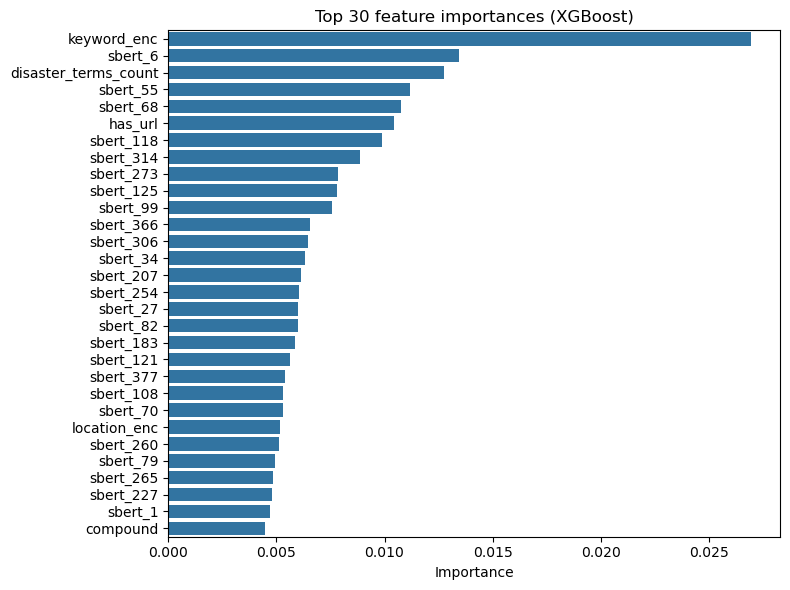

Pipeline guardado en xgb_sbert_pipeline.joblib


In [24]:
from matplotlib import pyplot as plt
import seaborn as sns

# 7) Importancia de features
# Extraer importancias del XGB entrenado (está dentro del pipeline)
best_xgb = best_pipe.named_steps['xgb']

# crear nombres de features: si tenés nombres originales de las n_tab columnas, úsalo
# por ejemplo, si tenías una lista `tab_feature_names`, úsala. Sino generamos etiquetas.
try:
    tab_feature_names = num_features + bool_features
except NameError:
    tab_feature_names = [f"tab_{i}" for i in range(n_tab)]

emb_feature_names = [f"sbert_{i}" for i in range(n_emb)]
feature_names = tab_feature_names + emb_feature_names

# Obtener importancias (gain/weight/cover). XGBoost expone feature_importances_ (por defecto gain)
importances = best_xgb.feature_importances_
# ordenar
idx_sorted = np.argsort(importances)[::-1]
top_k = 30
top_idx = idx_sorted[:top_k]

plt.figure(figsize=(8, max(4, top_k*0.2)))
sns.barplot(x=importances[top_idx], y=[feature_names[i] for i in top_idx])
plt.title(f"Top {top_k} feature importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# 8) (Opcional) Guardar modelo
import joblib
joblib.dump(grid.best_estimator_, "xgb_sbert_pipeline.joblib")
print("Pipeline guardado en xgb_sbert_pipeline.joblib")